<a href="https://colab.research.google.com/github/MiguelEuripedes/embedded_AI/blob/main/Projects/first_image_classifier/cnn_classifier/trian_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Your First Image Classifier: Using CNN to Classify Images

## Train

The purpose of this dataset is to correctly classify an image as containing a dog, cat, or panda. Containing only 3,000 images, the Animals dataset is meant to be another introductory dataset that we can quickly train a CNN model and obtain a comparative results with the previous KNN model.

Let's take the following steps:

1. Encoding target variable
2. Training the CNN model
3. Export the model and the encoder object

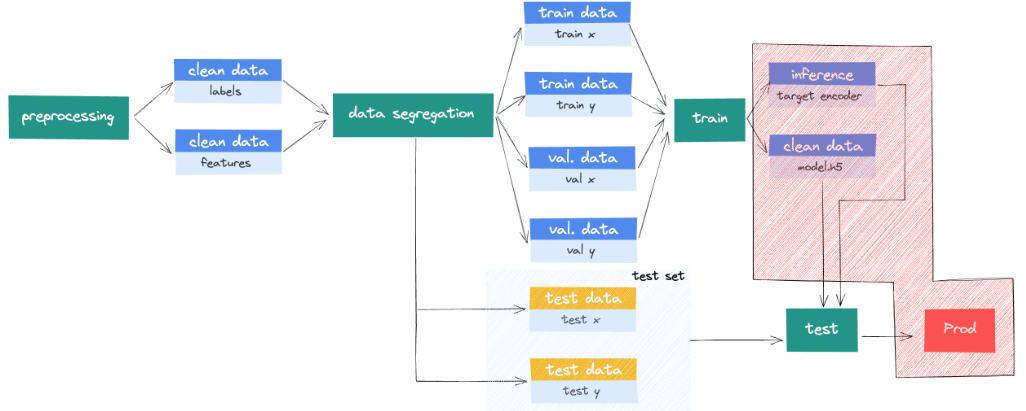

## Step 01: Setup
Start out by installing the experiment tracking library and setting up your free W&B account:

* **pip install wandb** – Install the W&B library
* **import wandb** – Import the wandb library
* **wandb login** – Login to your W&B account so you can log all your metrics in one place

In [ ]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 13.9 MB/s 
     |████████████████████████████████| 162 kB 72.6 MB/s 
     |████████████████████████████████| 182 kB 67.1 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 162 kB 57.7 MB/s 
     |████████████████████████████████| 158 kB 53.5 MB/s 
     |████████████████████████████████| 157 kB 58.3 MB/s 
     |████████████████████████████████| 157 kB 57.6 MB/s 
     |████████████████████████████████| 157 kB 29.5 MB/s 
     |████████████████████████████████| 157 kB 44.5 MB/s 
     |████████████████████████████████| 157 kB 48.7 MB/s 
     |████████████████████████████████| 157 kB 27.0 MB/s 
     |████████████████████████████████| 157 kB 51.5 MB/s 
     |████████████████████████████████| 156 kB 58.3 MB/s 


In [ ]:
# a Python package for tracking the carbon emissions produced by various
# kinds of computer programs, from straightforward algorithms to deep neural networks.
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 14.2 MB/s 
     |████████████████████████████████| 46 kB 5.4 MB/s 
     |████████████████████████████████| 99 kB 10.8 MB/s 
     |████████████████████████████████| 66 kB 5.3 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=669ebda8fe0c8f78693b93466132b94e4a203cfba0714cd0172d54e9df0d4cbc
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
Successfully built py-cpuinfo


### Important Packages

In [ ]:
import logging
import joblib
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
from codecarbon import EmissionsTracker
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback
import os
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import wandb

In [ ]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

## Step 02 Basic configuration and download artifacts

In [ ]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "cnn_classifier",
  "train_feature_artifact": "train_x:latest",
  "train_target_artifact": "train_y:latest",
  "val_feature_artifact": "val_x:latest",
  "val_target_artifact": "val_y:latest",
  "encoder": "target_encoder",
  "inference_model": "model.h5"
}

In [ ]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="euripedes",project=args["project_name"], job_type="Train")

logger.info("Downloading the train and validation data")
# train x
train_x_artifact = run.use_artifact(args["train_feature_artifact"])
train_x_path = train_x_artifact.file()

# train y
train_y_artifact = run.use_artifact(args["train_target_artifact"])
train_y_path = train_y_artifact.file()

# validation x
val_x_artifact = run.use_artifact(args["val_feature_artifact"])
val_x_path = val_x_artifact.file()

# validation y
val_y_artifact = run.use_artifact(args["val_target_artifact"])
val_y_path = val_y_artifact.file()

# unpacking the artifacts
train_x = joblib.load(train_x_path)
train_y = joblib.load(train_y_path)
val_x = joblib.load(val_x_path)
val_y = joblib.load(val_y_path)

wandb: Currently logged in as: euripedes. Use `wandb login --relogin` to force relogin


16-10-2022 19:27:14 Downloading the train and validation data


In [ ]:
logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Validation x: {}".format(val_x.shape))
logger.info("Validation y: {}".format(val_y.shape))

16-10-2022 19:27:31 Train x: (1687, 32, 32, 3)
16-10-2022 19:27:31 Train y: (1687,)
16-10-2022 19:27:31 Validation x: (563, 32, 32, 3)
16-10-2022 19:27:31 Validation y: (563,)


In [ ]:
train_x[4]

In [ ]:
train_y[4]

'cats'

## Step 03: Encoder the target variable

In [ ]:
# encode the labels as Binarizers
lb = LabelBinarizer()

# take care not to produce data lakeage
train_y = lb.fit_transform(train_y)
val_y = lb.transform(val_y)

In [ ]:
lb.classes_

array(['cats', 'dogs', 'panda'], dtype='<U5')

In [ ]:
train_y[4]

array([1, 0, 0])

In [ ]:
val_y[3]

array([0, 1, 0])

## Step 04: Model definition

Source code based on Rosebrock, Adrian. Deep Learning For Computer vision with Python, 2019 [link](https://pyimagesearch.com/deep-learning-computer-vision-python-book/)

In [ ]:
class ShallowNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last"
		model = Sequential()
		inputShape = (height, width, depth)

		# if we are using "channels first", update the input shape
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)

		# define the first (and only) CONV => RELU layer
		model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
		model.add(Activation("relu"))
	
		# softmax classifier
		model.add(Flatten())
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [ ]:
# create a model object
model = ShallowNet.build(32,32,3,3)

# summarize layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 3)                 98307     
                                                                 
 activation_1 (Activation)   (None, 3)                 0         
                                                                 
Total params: 99,203
Trainable params: 99,203
Non-trainable params: 0
_________________________________________________________________


## Step 05: Training

In [ ]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(learning_rate=0.005)
model = ShallowNet.build(width=32, height=32, depth=3, classes=3)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

# train the network
print("[INFO] training network...")
history = model.fit(train_x, train_y, 
              validation_data=(val_x, val_y),
              batch_size=32, 
              epochs=100, 
              verbose=0,
              callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                   compute_flops=True)]
          )

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

[INFO] compiling model...
[INFO] training network...


16-10-2022 19:27:57 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_ops.py:5219: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


## Step 06: Evaluation Metrics

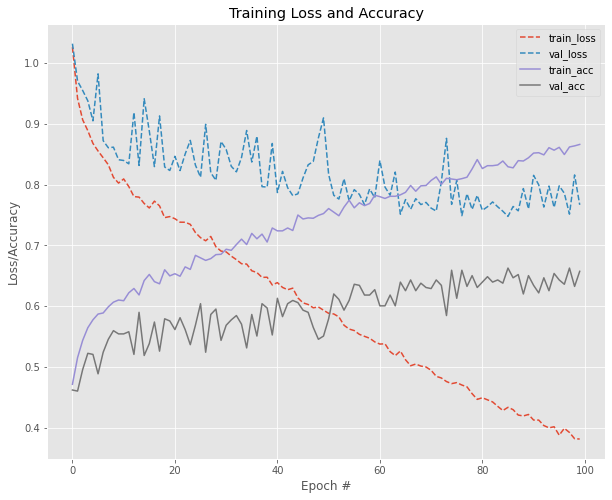

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 100), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 100), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 100), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 100), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [ ]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.0007303941414744871 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 4.193867621996826e-05 kWh
[INFO] Energy consumed for all GPU: 0.0003132725541631381 kWh
[INFO] Energy consumed for all CPU: 0.0003751829110913806 kWh
[INFO] CO2 emission 0.00023226533698888688(in Kg)


In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(val_x, batch_size=32)
print(classification_report(val_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=lb.classes_))

[INFO] evaluating network...
18/18 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

        cats       0.58      0.68      0.62       198
        dogs       0.51      0.42      0.46       159
       panda       0.84      0.83      0.83       206

    accuracy                           0.66       563
   macro avg       0.64      0.64      0.64       563
weighted avg       0.66      0.66      0.65       563



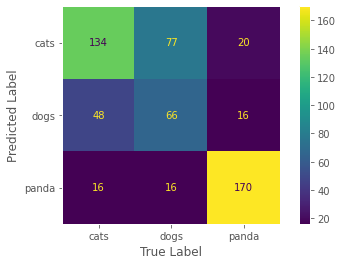

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                        val_y.argmax(axis=1)),
                       display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

16-10-2022 19:28:50 Uploading figures


In [ ]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(val_y.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(val_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(val_y.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(val_y.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

16-10-2022 19:28:53 Validation Evaluation metrics
16-10-2022 19:28:53 Validation Accuracy: 0.6571936056838366
16-10-2022 19:28:53 Validation Precision: 0.6553224803088511
16-10-2022 19:28:53 Validation Recall: 0.6571936056838366
16-10-2022 19:28:53 Validation F1: 0.6536089018280934


In [ ]:
logger.info("Dumping the model and encoder artifacts to the disk")

# Save the artifacts using joblib
joblib.dump(lb, args["encoder"])
model.save(os.path.join(wandb.run.dir, args["inference_model"]))

16-10-2022 19:28:57 Dumping the model and encoder artifacts to the disk


In [ ]:
# encoder artifact
artifact = wandb.Artifact(args["encoder"],
                          type="INFERENCE_MODEL",
                          description="A json file representing the target encoder"
                          )

logger.info("Logging the target encoder artifact")
artifact.add_file(args["encoder"])
run.log_artifact(artifact)

16-10-2022 19:28:59 Logging the target encoder artifact


In [ ]:
# inference model artifact
artifact = wandb.Artifact(args["inference_model"],
                          type="INFERENCE_MODEL",
                          description="A json file representing the inference model"
                          )

logger.info("Logging the inference model artifact")
artifact.add_file(os.path.join(wandb.run.dir, args["inference_model"]))
run.log_artifact(artifact)

16-10-2022 19:29:02 Logging the inference model artifact


In [ ]:
run.finish()

accuracy,▁▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▂▂▄▄▃▄▃▅▅▆▅▅▅▅▆▆▆▆▄▅▆▇▇▆▆▇▇▇▅███▇█▇▇▇▇█
val_loss,█▆▇▄▃▅▄▅▃▄▃▃▄▃▃▂▂▂▃▄▃▃▂▂▃▃▁▁▁▄▁▁▁▁▁▂▂▂▂▁
Acc,0.65719
CO2_Emissions,0.00023
Count_Params,99203
Energy_CPU,0.00038
Energy_Consumed,0.00073
Energy_GPU,0.00031


How can we improve this model?

* Data Augmentation Link
* Batch Normalization
* Dropout
* Add more CNN layers
* Add more hidden layers in the head

## Step 07: Sweep (hyperparameter tuning)


In [ ]:
# Configure the sweep 
sweep_config = {
    'method': 'random', 
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'conv_layer': {
            'max': 3,
            'min': 1,
            'distribution': 'int_uniform',
        },
        'hidden_layer': {
            'values': [0,1,2,3]
        },
        'learn_rate': {
            'values': [0.01,0.001,0.005],  
        },
        'epoch': {
            'values': [100,200]
        },
        'batch_size': {
            'values': [32,64]
        }
    }
}

In [ ]:
# Initialize a new sweep
# Arguments:
#     – sweep_config: the sweep config dictionary defined above
#     – entity: Set the username for the sweep
#     – project: Set the project name for the sweep
sweep_id = wandb.sweep(sweep_config,
                       entity="euripedes",
                       project=args["project_name"])

Create sweep with ID: 696jxme5
Sweep URL: https://wandb.ai/euripedes/cnn_classifier/sweeps/696jxme5


Adapt the model

In [ ]:
class ShallowNetAdapt:
  @staticmethod
  def build(width, height, depth, classes, config):
    '''
      width, height, depth: dimensions of the image
      classes: number of targets
      config: variable used to configure the sweep
    '''
    # initialize the model along with the input shape to be
    # "channels last"
    model = Sequential()
    inputShape = (height, width, depth)

    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)

    for i in range(config.conv_layer):
      # define a convolution layer followed by a relu activation 
      # CONV => RELU layer
      model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
      model.add(Activation("relu"))

    # add a flatten layer
    model.add(Flatten())

    # add hidden layers followed by a relu activation
    for j in range(config.hidden_layer):
      model.add(Dense(10,activation="relu"))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model

Training

In [ ]:
def train():
    with wandb.init() as run:

      # create codecarbon tracker
      # codecarbon is too much verbose, change the log level for more info
      tracker = EmissionsTracker(log_level="critical")
      tracker.start()

      # initialize the optimizer and model
      print("[INFO] compiling model...")
      opt = SGD(learning_rate=run.config.learn_rate)
      model = ShallowNetAdapt.build(width=32, 
                               height=32,
                               depth=3, 
                               classes=3,
                               config=run.config)
      model.compile(loss="categorical_crossentropy", 
                    optimizer=opt,metrics=["accuracy"])

      # train the network
      print("[INFO] training network...")
      history = model.fit(train_x, train_y, 
                    validation_data=(val_x, val_y),
                    batch_size=run.config.batch_size, 
                    epochs=run.config.epoch, 
                    verbose=0,
                    callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                        compute_flops=True)]
                )

      # get co2 emissions from tracker
      # "CO2 emission (in Kg)"
      emissions = tracker.stop()

      # make predictions
      predictions = model.predict(val_x, batch_size=run.config.batch_size)

      # Evaluation Metrics
      logger.info("Validation Evaluation metrics")
      fbeta = fbeta_score(val_y.argmax(axis=1), 
                          predictions.argmax(axis=1), 
                          beta=1, zero_division=1,average='weighted')
      precision = precision_score(val_y.argmax(axis=1),
                                  predictions.argmax(axis=1),
                                  zero_division=1,average='weighted')
      recall = recall_score(val_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
      acc = accuracy_score(val_y.argmax(axis=1),
                          predictions.argmax(axis=1))

      logger.info("Validation Accuracy: {}".format(acc))
      logger.info("Validation Precision: {}".format(precision))
      logger.info("Validation Recall: {}".format(recall))
      logger.info("Validation F1: {}".format(fbeta))

      run.summary["Acc"] = acc
      run.summary["Precision"] = precision
      run.summary["Recall"] = recall
      run.summary["F1"] = fbeta
      # number of parameters
      run.summary["Count_Params"] = model.count_params()
      # energy unit is kWh
      run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
      run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
      run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
      run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
      # kg
      run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

In [ ]:
# Initialize a new sweep
# Arguments:
#     – sweep_id: the sweep_id to run - this was returned above by wandb.sweep()
#     – function: function that defines your model architecture and trains it
wandb.agent(sweep_id = sweep_id, function=train,count=3)

wandb: Agent Starting Run: q7vjo29h with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 3
wandb: 	epoch: 100
wandb: 	hidden_layer: 3
wandb: 	learn_rate: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
9/9 [==============================] - 0s 3ms/step


16-10-2022 19:30:06 Validation Evaluation metrics
16-10-2022 19:30:06 Validation Accuracy: 0.6163410301953819
16-10-2022 19:30:06 Validation Precision: 0.5856617271258706
16-10-2022 19:30:06 Validation Recall: 0.6163410301953819
16-10-2022 19:30:06 Validation F1: 0.5900349680476538


accuracy,▁▁▂▂▂▃▄▄▅▅▅▅▆▆▅▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁
val_accuracy,▁▁▂▂▂▂▄▅▅▅▆▆▆▆▅▅▆▆▇▇▆▇▆▆▇▇▇▇▆▇▆▇▇▇▇▆▇▅██
val_loss,▇▇▆▆▆▆▆▅▅▅▅▄▅▃▄▅▃▃▂▃▂▂▂▆▂▂▁▃▅▄▃▂▁▂▂▅▃█▁▁
Acc,0.61634
CO2_Emissions,0.00023
Count_Params,347335
Energy_CPU,0.00026
Energy_Consumed,0.00072
Energy_GPU,0.00043


wandb: Agent Starting Run: ndpo2h0y with config:
wandb: 	batch_size: 32
wandb: 	conv_layer: 1
wandb: 	epoch: 100
wandb: 	hidden_layer: 3
wandb: 	learn_rate: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
18/18 [==============================] - 0s 2ms/step


16-10-2022 19:31:07 Validation Evaluation metrics
16-10-2022 19:31:07 Validation Accuracy: 0.6642984014209592
16-10-2022 19:31:07 Validation Precision: 0.6856965716009249
16-10-2022 19:31:07 Validation Recall: 0.6642984014209592
16-10-2022 19:31:07 Validation F1: 0.6158334264906201


accuracy,▁▂▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁
val_accuracy,▁▂▃▄▃▄▅▄▃▄▄▄▄▄▆▄▄▄▄▅▅▅▅▇▆▇▆▅▇▆▇▆▇▆█▆▇█▆█
val_loss,▆▆▅▅▄▄▄▄▄▃▃▃▃▃▂▃▄▄▃▂▂▂▂▁▂▁▂▃▂▂▂▂▃▃▂▄▃▃▄█
Acc,0.6643
CO2_Emissions,0.0003
Count_Params,328839
Energy_CPU,0.00049
Energy_Consumed,0.00095
Energy_GPU,0.0004


wandb: Agent Starting Run: hjwd12n2 with config:
wandb: 	batch_size: 32
wandb: 	conv_layer: 1
wandb: 	epoch: 100
wandb: 	hidden_layer: 0
wandb: 	learn_rate: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
18/18 [==============================] - 0s 2ms/step


16-10-2022 19:31:50 Validation Evaluation metrics
16-10-2022 19:31:50 Validation Accuracy: 0.6412078152753108
16-10-2022 19:31:50 Validation Precision: 0.6559846609565649
16-10-2022 19:31:50 Validation Recall: 0.6412078152753108
16-10-2022 19:31:50 Validation F1: 0.6424080522865557


accuracy,▁▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▆▆▆▇▇▇▇▇▇▇█▇██████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▂▁▄▄▅▆▅▆▆▅▆▆▆▇▄▆▆▆▇▇▆▆▇▇▇██▇▇█▇▆█▇███▇█▇
val_loss,█▇▅▄▃▃▄▃▃▅▃▃▂▂▄▂▃▃▂▁▂▃▂▂▂▁▁▂▂▁▁▃▂▂▂▂▁▂▂▂
Acc,0.64121
CO2_Emissions,0.00017
Count_Params,99203
Energy_CPU,0.00026
Energy_Consumed,0.00053
Energy_GPU,0.00024


In [ ]:
run.finish()